#Google CoLab 说明

以下代码检查是否正在运行 Google CoLab。

In [1]:
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [ ]:
# HIDE OUTPUT
!pip install transformers transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install transformers[sentencepiece] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00


#Fine Tune a Pretrained Model




#Another way to fine tune a model with the Trainer API


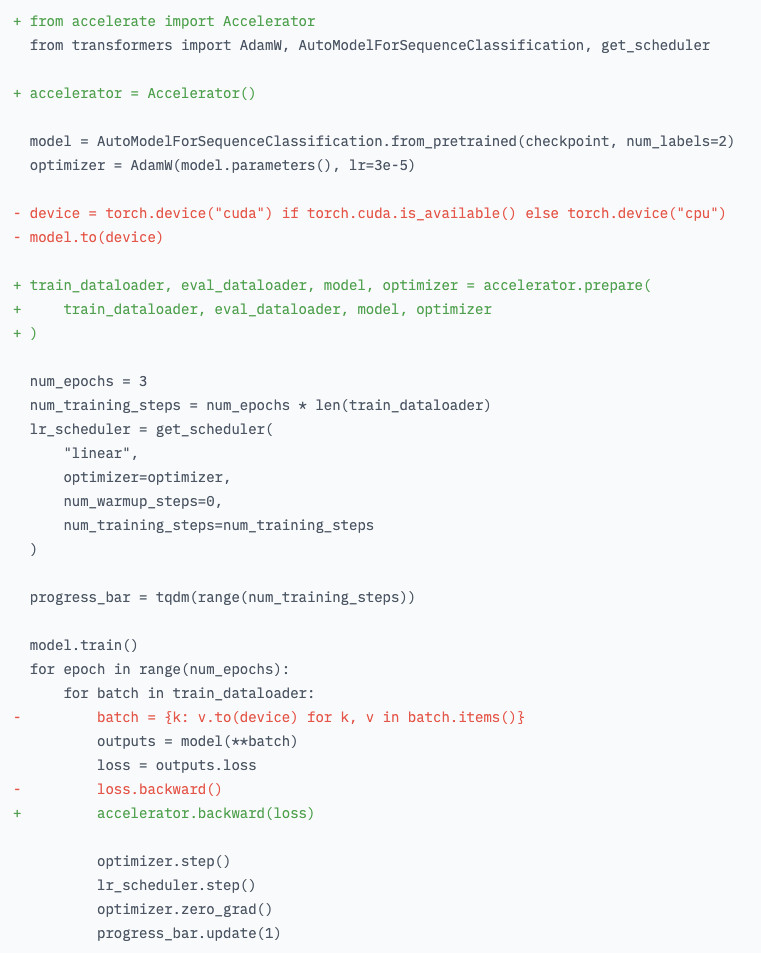

以下代码示例假设您已经执行了上一节中的示例。这里是一个简短的总结，回顾一下您需要的内容：

In [5]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████████████████████| 408/408 [00:00<00:00, 19719.71 examples/s]


#Training


现在我们将看到如何在不使用 Trainer 类的情况下实现与上一节相同的结果。

NEED GPU!!!!

#Prepare for training

在实际编写训练循环之前，我们需要定义一些对象。首先是我们将用于迭代批次的数据加载器。但在我们定义这些数据加载器之前，我们需要对我们的 tokenized_datasets 进行一些后处理，以处理一些 Trainer 自动为我们处理的事项。具体而言，我们需要：

1. 删除模型不期望的值对应的列（如 sentence1 和 sentence2 列）。
2. 将列 label 重命名为 labels（因为模型期望参数命名为 labels）。
3. 设置数据集的格式，使其返回 PyTorch 张量而不是列表。

我们的 tokenized_datasets 为这些步骤中的每一个都有一个方法：

In [6]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

然后，我们可以检查结果只包含我们的模型将接受的列：

["attention_mask", "input_ids", "labels", "token_type_ids"]

现在这一步完成了，我们可以轻松地定义我们的数据加载器：

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

为了快速检查数据处理中是否没有错误，我们可以像这样检查一个批次：

In [8]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 66]),
 'token_type_ids': torch.Size([8, 66]),
 'attention_mask': torch.Size([8, 66])}

请注意，实际的形状可能会稍有不同，因为我们为训练数据加载器设置了 shuffle=True，并且我们在批次内填充到最大长度。

现在我们已经完成了数据预处理（对于任何机器学习从业者来说，这是一个令人满意但又难以捉摸的目标），让我们转向模型。我们将其实例化，方式与上一节完全相同：

In [9]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

为了确保在训练过程中一切顺利，我们将我们的批次传递给这个模型：

In [10]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.4076, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


所有 🤗 Transformers 模型在提供标签时都会返回损失，我们还会得到 logits（对于批次中的每个输入都有两个，因此是大小为 8 x 2 的张量）。

我们几乎已经准备好编写我们的训练循环了！我们只缺两样东西：一个优化器和一个学习率调度器。由于我们尝试手动复制 Trainer 的操作，我们将使用相同的默认值。Trainer 使用的优化器是 AdamW，与 Adam 相同，但加入了一些关于权重衰减正则化的变化（参见 Ilya Loshchilov 和 Frank Hutter 的“[Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101)”）：

In [11]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

/Users/apple/miniforge3/envs/LLM/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


最后，默认使用的学习率调度器只是从最大值（5e-5）线性衰减到0。为了正确定义它，我们需要知道我们将进行的训练步数，这是我们想要运行的 epoch 数乘以训练批次的数量（即我们的训练数据加载器的长度）。Trainer 默认使用三个 epochs，所以我们将遵循这个设置：

In [12]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

1377


#The training loop

最后一件事：如果有 GPU 可以使用，我们将希望使用它（在 CPU 上，训练可能需要几个小时而不是几分钟）。为了做到这一点，我们定义一个设备，我们将在上面放置我们的模型和我们的批次：


In [13]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")
model.to(device)
device

device(type='mps')

我们现在准备好进行训练了！为了对训练何时结束有一些了解，我们通过使用 tqdm 库在我们的训练步数上添加了一个进度条：

In [14]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

100%|███████████████████████████████████████| 1377/1377 [04:27<00:00,  1.48it/s]

您可以看到训练循环的核心很像介绍中的循环。我们没有要求任何报告，因此此训练循环不会告诉我们有关模型表现的任何信息。为此，我们需要添加一个评估循环。

#The evaluation loop

就像之前一样，我们将使用 🤗 Evaluate 库提供的度量标准。我们已经看到了 metric.compute() 方法，但是度量标准实际上可以在我们通过 add_batch() 方法遍历预测循环时为我们累积批次。一旦我们积累了所有批次，我们就可以使用 metric.compute() 获取最终结果。以下是如何在评估循环中实现所有这些的方法：

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.2 MB/s eta 0:00:00


In [16]:
import evaluate

metric = evaluate.load("glue", "mrpc")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'accuracy': 0.8602941176470589, 'f1': 0.9015544041450777}

同样，由于模型头初始化和数据洗牌的随机性，您的结果可能会略有不同，但它们应该在相同的范围内。

#Supercharge your training loop with 🤗 Accelerate


我们之前定义的训练循环在单个 CPU 或 GPU 上运行良好。但是使用 🤗 Accelerate 库，只需进行一些调整，我们就可以在多个 GPU 或 TPU 上启用分布式训练。

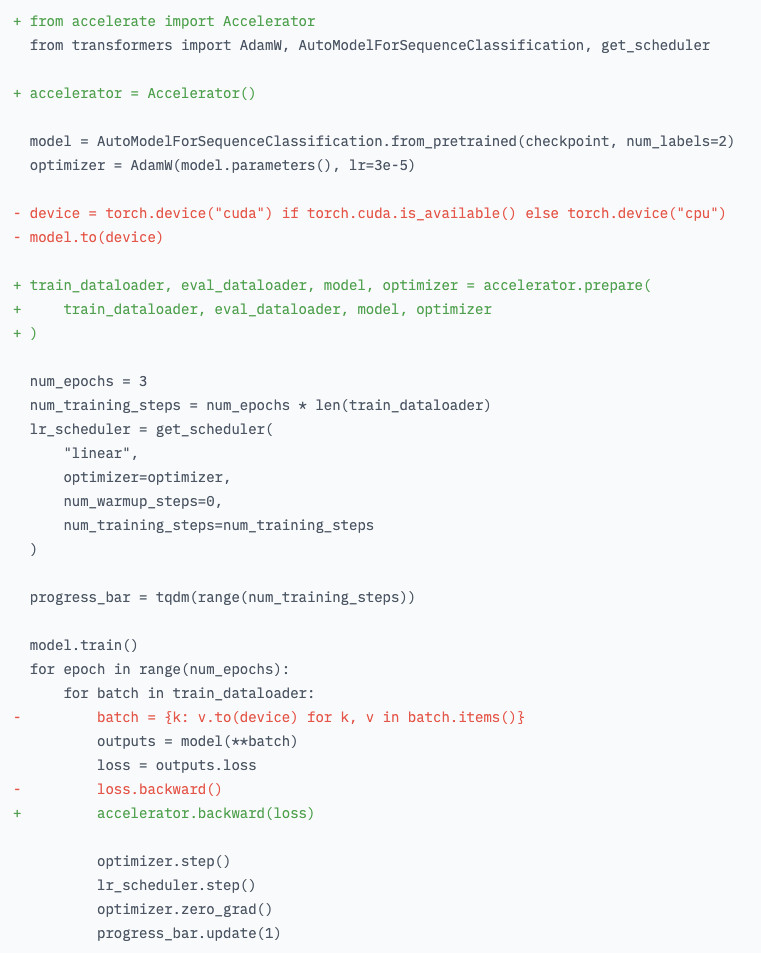

完整的脚本：

In [ ]:
from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

accelerator = Accelerator()

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

num_epochs = 3
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dl:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)